In [20]:
# all required imports
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from geopy.distance import geodesic
import json
import os
import sys
import math
import random
import datetime
import scipy as sp
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
#reading the training data and test data
json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']

train_data = pd.read_csv("./Data/train.csv", low_memory=False, error_bad_lines=False, header=0,
                         dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, 
                         converters={column: json.loads for column in json_cols}, nrows=None)

# Reference: https://www.kaggle.com/vishalbajaj2000/google-analytics-first-try-lgbm-lb-1-5986
# adding subcolumns from json columns in training data
for col_name in json_cols:
    column_as_df = json_normalize(train_data[col_name])
    column_as_df.columns = [f"{col_name}.{subcolumn}" for subcolumn in column_as_df.columns]
    train_data = train_data.drop(col_name, axis=1).merge(column_as_df, right_index=True, left_index=True)


test_data = pd.read_csv("./Data/test.csv", low_memory=False, error_bad_lines=False, header=0,
                         dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, 
                         converters={column: json.loads for column in json_cols}, nrows=None)

for col_name in json_cols:
    column_as_df = json_normalize(test_data[col_name])
    column_as_df.columns = [f"{col_name}.{subcolumn}" for subcolumn in column_as_df.columns]
    test_data = test_data.drop(col_name, axis=1).merge(column_as_df, right_index=True, left_index=True)

print(train_data.keys())

id_columns = ['fullVisitorId', 'sessionId', 'visitId']

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

In [22]:
# handling NaN values in relevant columns

def replace_nan_with_zero(cols):
    for col in cols:
        train_data[col].fillna(0,inplace=True)
        if col != 'totals.transactionRevenue':
            test_data[col].fillna(0,inplace=True)
    
cols = ['trafficSource.adwordsClickInfo.page', 'trafficSource.isTrueDirect', 'totals.newVisits', 'totals.bounces'
        , 'totals.transactionRevenue']
replace_nan_with_zero(cols)

#train_data.dropna(how = 'any', axis = 'rows')

In [23]:
# changing dtype of columns from string to int
cols = ['totals.transactionRevenue', 'totals.hits', 'totals.pageviews']

for col in cols:
    train_data[col] = pd.to_numeric(train_data[col])
    if col != 'totals.transactionRevenue':
        test_data[col] = pd.to_numeric(test_data[col])
    

In [ ]:
# deleting columns with too many NaN values
cols = train_data.keys()

# percentage of nan values
for col in cols:
    nan_cnt = sum(pd.isnull(train_data[col]))
    percent = 100*nan_cnt/len(train_data[col])
    if percent > 80:
        print("%s has %s%% NaN, Deleting..." % (col, percent))
        del train_data[col]
        if col in test_data:
            del test_data[col]

col_with_nan = ['trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 
                'trafficSource.adwordsClickInfo.gclId','trafficSource.keyword', 'trafficSource.referralPath',
                'trafficSource.adwordsClickInfo.slot']

In [25]:
# deleting columns with just one unique

#col_with_one_unique_val = ['socialEngagementType', 'totals.visits'] # checked: ['campaign', 'source', 'medium']

cols = train_data.keys()
for col_name in cols:
    if len(train_data[col_name].unique()) == 1:
        print(train_data[col_name].unique())
        print("Deleted: '%s'" % (col_name))
        del train_data[col_name]
        del test_data[col_name]

['Not Socially Engaged']
Deleted: 'socialEngagementType'
['not available in demo dataset']
Deleted: 'device.browserSize'
['not available in demo dataset']
Deleted: 'device.browserVersion'
['not available in demo dataset']
Deleted: 'device.flashVersion'
['not available in demo dataset']
Deleted: 'device.language'
['not available in demo dataset']
Deleted: 'device.mobileDeviceBranding'
['not available in demo dataset']
Deleted: 'device.mobileDeviceInfo'
['not available in demo dataset']
Deleted: 'device.mobileDeviceMarketingName'
['not available in demo dataset']
Deleted: 'device.mobileDeviceModel'
['not available in demo dataset']
Deleted: 'device.mobileInputSelector'
['not available in demo dataset']
Deleted: 'device.operatingSystemVersion'
['not available in demo dataset']
Deleted: 'device.screenColors'
['not available in demo dataset']
Deleted: 'device.screenResolution'
['not available in demo dataset']
Deleted: 'geoNetwork.cityId'
['not available in demo dataset']
Deleted: 'geoNetwo

In [26]:
# deleting columns whose more than 60% values are censored

cols = train_data.keys()
# percentage of nan values
for col in cols:
    if train_data[col].dtype == 'O':
        nan_cnt = (train_data[col] == 'not available in demo dataset').sum()
        nan_cnt += (train_data[col] == '(not set)').sum()
        
        percent = 100*nan_cnt/len(train_data[col])
        if percent > 50:
            print("%s has %s%% censored data, Deleting..." % (col, percent))
            del train_data[col]
            del test_data[col]

geoNetwork.city has 60.03311005441248% censored data, Deleting...
geoNetwork.metro has 78.56942875196563% censored data, Deleting...
geoNetwork.region has 59.32100042826173% censored data, Deleting...
trafficSource.campaign has 95.76098347485151% censored data, Deleting...


In [27]:
# deleting columns which are not relevant for revenue prediction
col_to_del = ['geoNetwork.networkDomain', 'sessionId']

for col_name in col_to_del:
    del train_data[col_name]
    del test_data[col_name]

In [28]:
# functions to map string to int

unique_val_map = {}

def map_channel_grouping(column_name):
    if column_name not in unique_val_map:
        unique_val = train_data[column_name].unique()
        unique_val_map[column_name] = {}
        for i in range(len(unique_val)):
            unique_val_map[column_name][unique_val[i]] = i
    print("Mapped Values:")
    print(unique_val_map[column_name])
    train_data.channelGrouping = train_data[column_name].apply(lambda val: unique_val_map[column_name][val])

In [29]:
# adding year, month, day and day_of_week
for df in [train_data, test_data]:
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_month'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['hour'] = df['date'].dt.hour

del train_data['date']

In [30]:
# mapping values of columns having string values to int

#col_to_map = ['channelGrouping', 'device.isMobile']
col_to_map = train_data.keys()
for col_name in col_to_map:
    if train_data[col_name].dtype == 'O' and col_name not in id_columns:
        print(col_name)
        map_channel_grouping(col_name) 
        print('\n')

channelGrouping
Mapped Values:
{'Organic Search': 0, 'Referral': 1, 'Paid Search': 2, 'Affiliates': 3, 'Direct': 4, 'Display': 5, 'Social': 6, '(Other)': 7}


device.browser
Mapped Values:
{'Chrome': 0, 'Firefox': 1, 'UC Browser': 2, 'Internet Explorer': 3, 'Safari': 4, 'Edge': 5, 'Opera Mini': 6, 'Opera': 7, 'BlackBerry': 8, 'Safari (in-app)': 9, 'Coc Coc': 10, 'Mozilla Compatible Agent': 11, 'ADM': 12, 'MRCHROME': 13, 'Amazon Silk': 14, 'YaBrowser': 15, 'Android Webview': 16, 'Puffin': 17, 'Nokia Browser': 18, 'Maxthon': 19, 'Nintendo Browser': 20, 'Android Browser': 21, 'Lunascape': 22, 'IE with Chrome Frame': 23, 'ThumbSniper': 24, 'LYF_LS_4002_12': 25, 'Mozilla': 26, 'osee2unifiedRelease': 27, 'NokiaE52-1': 28, 'Iron': 29, '[Use default User-agent string] LIVRENPOCHE': 30, '(not set)': 31, 'LYF_LS_4002_11': 32, 'M5': 33, 'Android Runtime': 34, 'Apple-iPhone7C2': 35, 'SeaMonkey': 36, 'Konqueror': 37, 'Seznam': 38, 'Changa 99695759': 39, 'no-ua': 40, 'MQQBrowser': 41, 'Nichrome': 42



trafficSource.medium
Mapped Values:
{'organic': 0, 'referral': 1, 'cpc': 2, 'affiliate': 3, '(none)': 4, 'cpm': 5, '(not set)': 6}


trafficSource.referralPath
Mapped Values:
{nan: 0, '/': 1, '/corp/google.com/study/incentives/working-with-perks': 2, '/od/Things-To-Do-in-Silicon-Valley/fl/How-To-Visit-the-Googleplex-the-Google-Head-Office-in-Mountain-View.htm': 3, '/a/google.com/google-merchandise-store/on-site-store': 4, '/analytics/web/': 5, '/intl/en/permissions/using-the-logo.html': 6, '/permissions/using-the-logo.html': 7, '/YKEI_mrn/items/c10b14f9a69ff71b1b7a': 8, '/analytics/web/inpage_launch': 9, '/intl/de/permissions/using-the-logo.html': 10, '/intl/pl/permissions/using-the-logo.html': 11, '/a/google.com/google-merchandise-store/on-site-store/mountain-view-store': 12, '/intl/ALL/permissions/using-the-logo.html': 13, '/_/scs/mail-static/_/js/k=gmail.main.en.VSE1BHcxoTk.O/m=m_i,t,it/am=OotHDjBPxv3BuIZhQFf6Kt35738-vVR-6Oce1Z8IiCKvAv1v9v8A_g_kp20U/rt=h/d=1/rs=AHGWq9CcYnkIxVeeMRc



trafficSource.source
Mapped Values:
{'google': 0, 'baidu': 1, 'googleweblight.com': 2, 'sites.google.com': 3, 'bing': 4, 'siliconvalley.about.com': 5, 'analytics.google.com': 6, 'Partners': 7, '(direct)': 8, 'mall.googleplex.com': 9, 'google.com': 10, 'google.co.in': 11, 'qiita.com': 12, 'google.pl': 13, 'mail.google.com': 14, 'hangouts.google.com': 15, 'dealspotr.com': 16, 'optimize.google.com': 17, 'arstechnica.com': 18, 'dfa': 19, 'docs.google.com': 20, 'sashihara.jp': 21, 'google.gatewaycdi.com': 22, 'phandroid.com': 23, 'images.google': 24, 'youtube.com': 25, 'l.facebook.com': 26, 'facebook.com': 27, 'quora.com': 28, 'm.facebook.com': 29, 'reddit.com': 30, 'google.co.jp': 31, 'aol': 32, 'moma.corp.google.com': 33, 'blog.golang.org': 34, 'yahoo': 35, 't.co': 36, 'nordic.businessinsider.com': 37, 'duckduckgo.com': 38, 'm.baidu.com': 39, 'tpc.googlesyndication.com': 40, 'googleads.g.doubleclick.net': 41, '0.shared.bow.cat2.ads-bow.vu.borg.google.com:9856': 42, 'online-metrics.com':

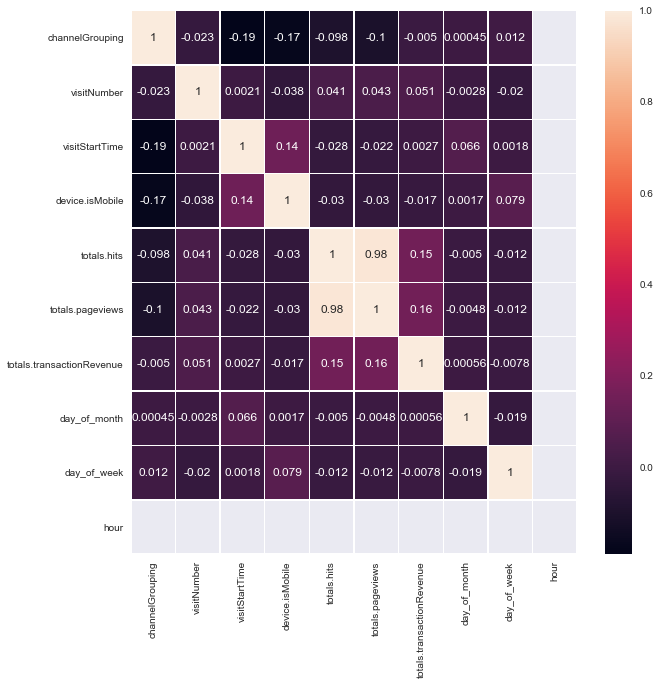

In [31]:
#print(train_data.isnull().sum())
correlation_cols = ['channelGrouping', 'visitNumber', 'visitStartTime', 'device.browser',
                   'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
                   'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.subContinent',
                   'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews',
                   'totals.transactionRevenue', 'trafficSource.adwordsClickInfo.page',
                   'trafficSource.isTrueDirect', 'trafficSource.medium',
                   'trafficSource.source', 'day_of_month', 'day_of_week', 'hour']#,
#                   'trafficSource.keyword', 'trafficSource.referralPath']

sns.set()
correlation_data = train_data[correlation_cols]

correlation = correlation_data.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(correlation, annot=True, linewidths=.5, ax=ax)
plt.show()


In [32]:
i = 0
for key in train_data.keys():
    print("%s : % s ----- unique=%s" % (key, train_data.values[0][i], len(train_data[key].unique())))
    i += 1
print(i)

channelGrouping : 0 ----- unique=380
fullVisitorId : 1131660440785968503 ----- unique=714167
visitId : 1472830385 ----- unique=886303
visitNumber : 1 ----- unique=384
visitStartTime : 1472830385 ----- unique=887159
device.browser : Chrome ----- unique=54
device.deviceCategory : desktop ----- unique=3
device.isMobile : False ----- unique=2
device.operatingSystem : Windows ----- unique=20
geoNetwork.continent : Asia ----- unique=6
geoNetwork.country : Turkey ----- unique=222
geoNetwork.subContinent : Western Asia ----- unique=23
totals.bounces : 1 ----- unique=2
totals.hits : 1 ----- unique=274
totals.newVisits : 1 ----- unique=2
totals.pageviews : 1.0 ----- unique=214
totals.transactionRevenue : 0 ----- unique=5333
trafficSource.adwordsClickInfo.page : 0 ----- unique=9
trafficSource.isTrueDirect : 0 ----- unique=2
trafficSource.keyword : (not provided) ----- unique=3660
trafficSource.medium : organic ----- unique=7
trafficSource.referralPath : nan ----- unique=1476
trafficSource.source 

In [33]:
'''['channelGrouping', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page', 'trafficSource.isTrueDirect',
       'trafficSource.medium', 'trafficSource.source', 'day_of_month',
       'day_of_week', 'hour']
'''

def get_training_features(td):
    return np.column_stack((td['totals.pageviews'], td['totals.hits'], td.visitStartTime, td.hour, td.day_of_week,
                            td.day_of_month, np.ones(len(td))))

train_x = get_training_features(train_data)
test_x = get_training_features(test_data)

train_y = np.log1p(train_data['totals.transactionRevenue'].values)
train_data['totals.transactionRevenueLog'] = np.log1p(train_data['totals.transactionRevenue'].values)

# Linear Regression model initialization
linear_regression_adv = LinearRegression()

# Training the Linear Regression Model
linear_regression_adv.fit(train_x, train_y)
print(linear_regression_adv.coef_)

# Predict fare_amount for training data to get calculate errors
pre_test_y = linear_regression_adv.predict(train_x)

# Mean squared error and variance
print("Mean squared error: %.5f" % mean_squared_error(train_data['totals.transactionRevenueLog'], pre_test_y))
print('Variance : %.5f' % r2_score(train_data['totals.transactionRevenueLog'], pre_test_y)) #

# Predict revenue
test_y = linear_regression_adv.predict(test_x)

# write prediction to csv file
'''prediction_output = test_data[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum()[ \
                    'PredictedLogRevenue'].apply(np.log1p).reset_index()
prediction_output.to_csv('test_clf_reg_log_of_sum.csv', index=False)
'''

pred_data = pd.DataFrame({"fullVisitorId":test_data["fullVisitorId"].values})
test_y[test_y<0] = 0
pred_data["PredictedLogRevenue"] = np.expm1(test_y)
pred_data = pred_data.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
pred_data.columns = ["fullVisitorId", "PredictedLogRevenue"]
pred_data["PredictedLogRevenue"] = np.log1p(pred_data["PredictedLogRevenue"])
pred_data.to_csv("baseline_linearReg.csv", index=False)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# custom function to run light gbm model
def run_lgb(train_x, train_y, val_x, val_y, test_x):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_x, label=train_y)
    lgval = lgb.Dataset(val_x, label=val_y)
    model = lgb.train(params, lgtrain, 4000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_x, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_x, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

pre_test_y, model, test_y = run_lgb(train_x, train_y, train_x, train_y, test_x)

# Mean squared error and variance
print("Mean squared error: %.5f" % mean_squared_error(train_data['totals.transactionRevenueLog'], pre_test_y))
print('Variance : %.5f' % r2_score(train_data['totals.transactionRevenueLog'], pre_test_y)) #

# write prediction to csv file
'''prediction_output = test_data[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum()[ \
                    'PredictedLogRevenue'].apply(np.log1p).reset_index()
prediction_output.to_csv('test_clf_reg_log_of_sum.csv', index=False)
'''

pred_data = pd.DataFrame({"fullVisitorId":test_data["fullVisitorId"].values})
test_y[test_y<0] = 0
pred_data["PredictedLogRevenue"] = np.expm1(test_y)
pred_data = pred_data.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
pred_data.columns = ["fullVisitorId", "PredictedLogRevenue"]
pred_data["PredictedLogRevenue"] = np.log1p(pred_data["PredictedLogRevenue"])
pred_data.to_csv("baseline_lgb.csv", index=False)

In [ ]:
len(train_data)
